In [2]:
filename = 'eye_movements_1044'

import pandas as pd
df = pd.read_parquet('https://github.com/SAP-samples/portal/raw/refs/heads/main/data/fine_tune_data_50k_subsample'
                f'/classification/dirty/{filename}.parquet')

df.head()

,lineNo,assgNo,fixcount,firstPassCnt,P1stFixation,P2stFixation,prevFixDur,firstfixDur,firstPassFixDur,nextFixDur,...,regressLen,nextWordRegress,regressDur,pupilDiamMax,pupilDiamLag,timePrtctg,nWordsInTitle,titleNo,wordNo,label
0,1,1,1,1,1,0,0,100,100,99,...,0,0,0,0.0095,0.145,0.0131,7,4,3,0
1,2,1,1,1,1,0,99,278,278,159,...,0,0,0,0.0095,0.183,0.0363,7,1,1,0
2,3,1,1,1,1,0,278,159,159,159,...,0,0,0,0.0370,0.183,0.0208,7,1,3,0
3,4,1,1,1,1,0,159,159,159,139,...,0,0,0,0.0370,0.183,0.0208,7,1,5,0
4,5,1,1,1,1,0,159,139,139,239,...,0,0,0,0.0390,0.183,0.0182,7,1,6,0


In [3]:
len(df["label"].unique()) ## number of classes : 3

3

In [4]:
print(len(df.columns))

numerical_columns = []
for c in df.columns:
    if c not in ["label", "lineNo"]:
        try:
            df[c] = df[c].astype(float)
        except:
            print("proute")
        else:
            numerical_columns.append(c)
            
non_constant_columns = [c for c in numerical_columns if df[c].nunique() > 1]
df = df[non_constant_columns + ["label"]]

print(len(df.columns)) ### Still 28 columns because even the nominal columns are strings of floats 



28
27


ACP

In [5]:
from sklearn.decomposition import PCA
pca = PCA()
colonnes_x = [c for c in df.columns if c != 'label']

X = df[colonnes_x]
X = (X - X.mean()) / X.std()
cp = pca.fit_transform(X)
print(X.shape)
cp.shape


(10936, 26)


(10936, 26)

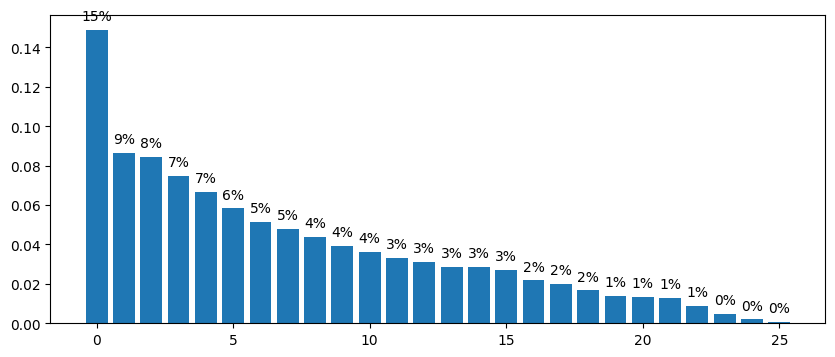

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 4))

plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
for i, var in enumerate(pca.explained_variance_ratio_):
    plt.text(i, var + 0.005, f'{var:.0%}', ha='center')

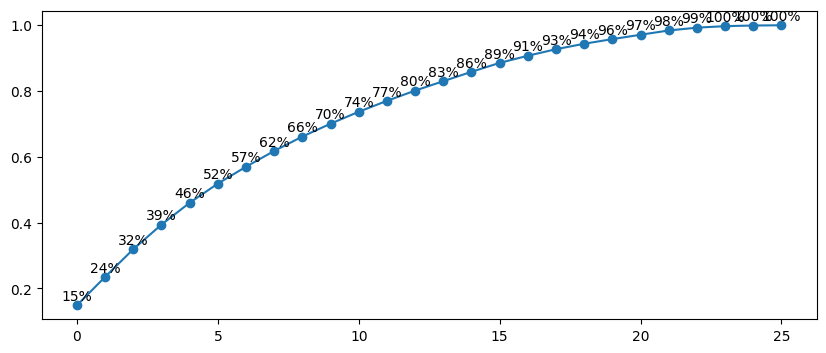

In [7]:
import numpy as np
In [25]: plt.figure(figsize=(10, 4))

plt.plot(np.cumsum(pca.explained_variance_ratio_), '-o')
for i, var in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    plt.text(i, var + 0.015, f'{var:.0%}', ha='center')

Non le premier plan n'explique que 39% de la variance totale, c'est mauvais.

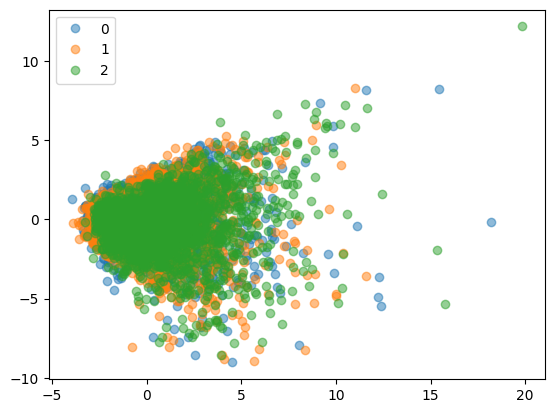

In [8]:
target = df['label']

plt.plot(cp[target == '0', 0], cp[target == '0', 1], 'o', label='0', alpha=0.5)
plt.plot(cp[target == '1', 0], cp[target == '1', 1], 'o', label='1', alpha=0.5)
plt.plot(cp[target == '2', 0], cp[target == '2', 1], 'o', label='2', alpha=0.5)
plt.legend()

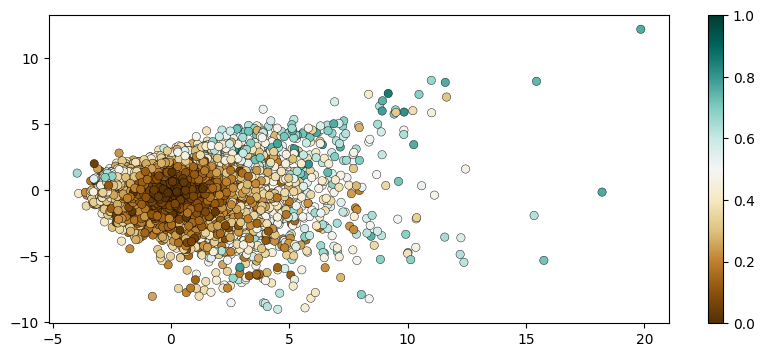

In [9]:
plt.figure(figsize=(10, 4))
numerateur = np.sum(cp[:, :2] ** 2, axis=1) # Y1**2 + Y2**2
normes2 = np.sum(cp ** 2, axis=1)
cosines2 = numerateur / normes2
plt.scatter(cp[:, 0], cp[:, 1], c=cosines2, cmap='BrBG', vmin=0, vmax=1, edgecolor='k', linewidth=0.3)
plt.colorbar()

(1, 2)
(26, 2)


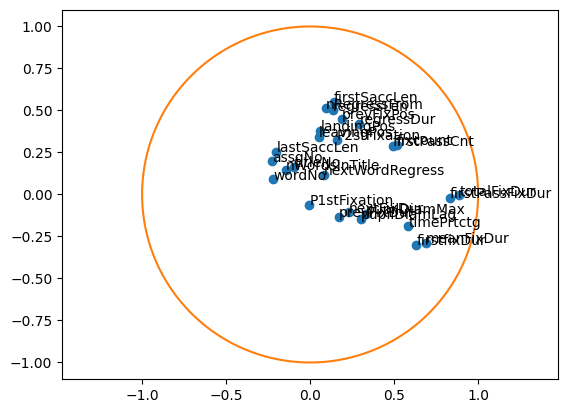

In [10]:
def cercle_correlation(axe1=0, axe2=1):
    racine_lambda_k = np.sqrt(pca.explained_variance_[None, [axe1, axe2]])
    print(racine_lambda_k.shape)
    u_kj = pca.components_[[axe1, axe2]].T
    print(u_kj.shape)
    corrs = racine_lambda_k * u_kj
    plt.plot(corrs[:, 0], corrs[:, 1], 'o')
    theta = np.linspace(0, 2*np.pi, 360)
    plt.plot(np.cos(theta), np.sin(theta))
    plt.gca().axis('equal')
    for name, (corr1, corr2) in zip(pca.feature_names_in_, corrs):
        # X.columns -> pca.feature_names_in_
        plt.text(corr1, corr2, name, fontsize=10)


cercle_correlation(0, 2)

(10936, 2)


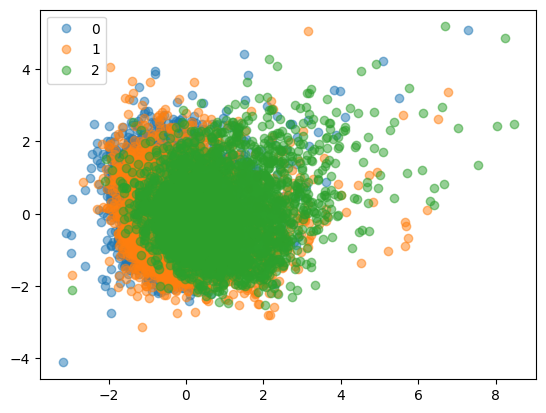

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
fd = lda.fit_transform(X, target)
print(fd.shape) ## on obtient 2 dimensions + justification ? 

plt.plot(fd[target == '0', 0], fd[target == '0', 1], 'o', label='0', alpha=0.5)
plt.plot(fd[target == '1', 0], fd[target == '1', 1], 'o', label='1', alpha=0.5)
plt.plot(fd[target == '2', 0], fd[target == '2', 1], 'o', label='2', alpha=0.5)
plt.legend()

In [12]:
preds = lda.predict(X)

accuracy = (preds == target).mean()
print(f'Accuracy : {accuracy:.1%}')

Accuracy : 51.0%


[[1745 1736  323]
 [1320 2379  563]
 [ 414 1000 1456]]


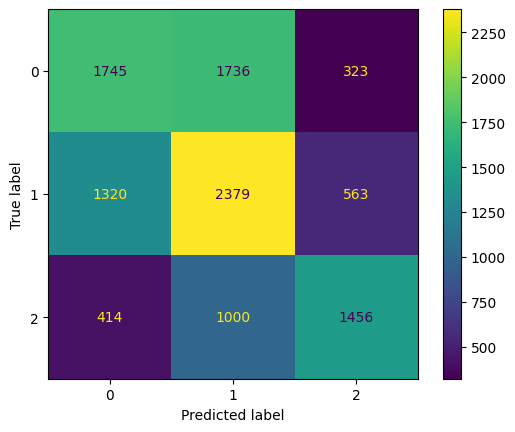

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(target, preds)
print(cm)

ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2]).plot()

Le modèle n'est pas suffisant bon. Il se trompe une fois sur deux.

SVM

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import LinearSVC
import numpy as np
from matplotlib import pyplot as plt

[  1.   1.   1. ... 336. 336. 336.]
(10936, 26)
[0. 0. 0. ... 2. 2. 2.]


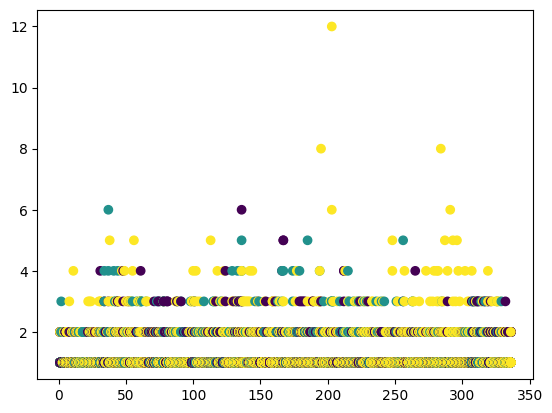

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, svm



colonnes_x = [c for c in df.columns if c not in ['label', 'lineNo']]

X = df[colonnes_x].to_numpy()
y = df["label"].astype(float).values

print(X[:, 0])
print(X.shape)
print(y)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [16]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Définir les caractéristiques (X) et la cible (y)
# colonnes_x = [c for c in df.columns if c not in ['label', "lineNo"]]
# X = df[colonnes_x[:2]].to_numpy()  # Convertir en tableau NumPy
# y = y = df['label'].astype(int).to_numpy()  # La colonne cible

# # Diviser les données en ensembles d'entraînement et de test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Normaliser les caractéristiques
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, classification_report

# # Initialiser une SVM avec un noyau linéaire
# svm = SVC(kernel='linear', random_state=42)

# # Entraîner la SVM
# svm.fit(X_train, y_train)

# # Prédire sur les données de test
# y_pred = svm.predict(X_test)

# # Évaluer la performance
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# def plot_decision_boundary(X, y, model):
#     # Créer un maillage pour la grille
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

#     # Prédire les classes pour chaque point de la grille
#     Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)

#     # Tracer la frontière de décision
#     plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')

#     # Ajouter les points de données
#     scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='viridis')
#     plt.colorbar(scatter)
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.title('SVM Decision Boundary')
#     plt.show()

# plot_decision_boundary(X_train, y_train, svm) 

False


c:\Users\falou\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


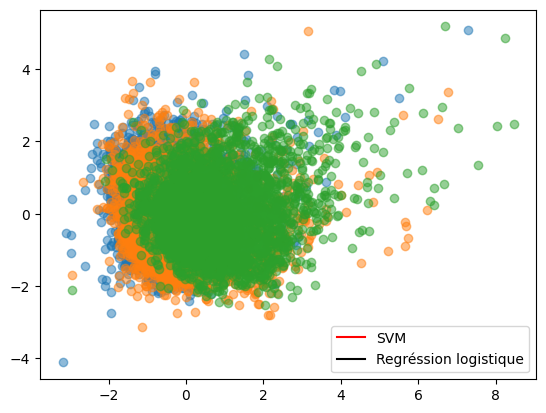

In [17]:
lr = LogisticRegression(penalty=None, max_iter=int(1e5))
svm_clf = LinearSVC(C=1000000, dual=True)  # C = infty signifie "pas de normalisation"

colonnes_x = [c for c in df.columns if c not in ['label', "lineNo"]]
print(colonnes_x[0:4:2] == colonnes_x[:2])
X = df[colonnes_x[0:4:2]].to_numpy()  # Convertir en tableau NumPy
y = df['label'].astype(int).to_numpy()  # La colonne cible

lr.fit(X, target)
svm_clf.fit(X, target)

plt.plot(fd[target == '0', 0], fd[target == '0', 1], 'o', label='0', alpha=0.5)
plt.plot(fd[target == '1', 0], fd[target == '1', 1], 'o', label='1', alpha=0.5)
plt.plot(fd[target == '2', 0], fd[target == '2', 1], 'o', label='2', alpha=0.5)
#DecisionBoundaryDisplay.from_estimator(lr, X, plot_method="contour", ax=plt.gca(), 
           #                                 levels=[-1, 0, 1], colors='k', linestyles=["--", "-", "--"])
#DecisionBoundaryDisplay.from_estimator(svm_clf, X, plot_method="contour", ax=plt.gca(), 
                                       #levels=[-1, 0, 1], colors='r', linestyles=["--", "-", "--"])
from matplotlib.lines import Line2D
plt.legend(handles=[Line2D([0], [0], color='r', label='SVM'), 
                    Line2D([0], [0], color='k', label='Regréssion logistique')])

(0.8, 8.2)

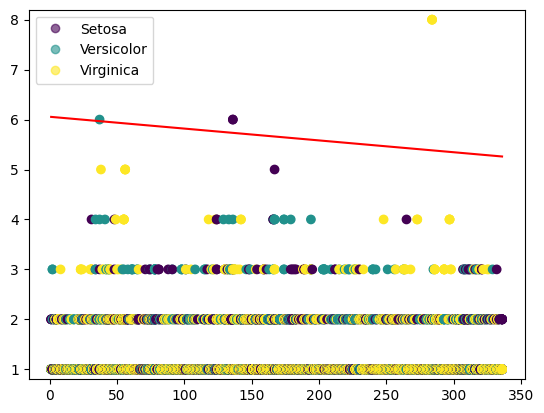

In [18]:
clf = LinearSVC(C=100000, dual=False, max_iter=100000)
clf.fit(X[:, :2], y > 1)
scatter = plt.scatter(X[:, 0], X[:, 1], c=y)
handles, labels = scatter.legend_elements(alpha=0.6)
plt.legend(handles, ['Setosa', 'Versicolor', 'Virginica'])
x_min = X[:, 0].min()
x_max = X[:, 0].max()
a, b = clf.coef_[0]
c = clf.intercept_[0]
x = np.array([x_min, x_max])
plt.plot(x, -a/b * x - c/b, 'r')
plt.plot(x, -a/b * x - (c+1)/b, 'r--')
plt.plot(x, -a/b * x - (c-1)/b, 'r--')
plt.ylim([X[:, 1].min() - .2, X[:, 1].max() + .2])

In [19]:
# clf = svm.SVC(kernel='rbf', gamma=10)
# clf.fit(X[:, :2], y)
# scatter = plt.scatter(X[:, 0], X[:, 1], c=y)
# handles, labels = scatter.legend_elements(alpha=0.6)
# plt.legend(handles, ['Setosa', 'Versicolor', 'Virginica'])
# ax = plt.gca()
# DecisionBoundaryDisplay.from_estimator(
#     clf,
#     X[:, :2],
#     colors='r',
#     plot_method="contour",
#     alpha=0.5,
#     ax=ax,
#     grid_resolution=1000,)

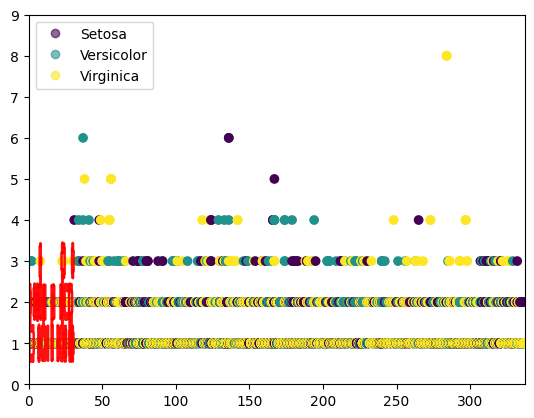

In [23]:
clf = svm.SVC(kernel='rbf', gamma=10)
clf.fit(X[:1000, :2], y[:1000])
scatter = plt.scatter(X[:, 0], X[:, 1], c=y)
handles, labels = scatter.legend_elements(alpha=0.6)
plt.legend(handles, ['Setosa', 'Versicolor', 'Virginica'])
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X[:, :2],
    colors='r',
    plot_method="contour",
    alpha=0.5,
    ax=ax,
    grid_resolution=1000,)